# Classical shadows of qutrits

In this notebook we approach our qutrit tomography problem with some classical simulations. This notebook provides some more details around the `shadow.py` module as well some of the theory around shadow tomography. Much of the theory can be found in Ref. [1]. Classical shadows are a relatively new approach for reconstructing properties a quantum system from very few (random) measurements. 

The goal here was to implement:
- a characterisation method for qutrits
- that is efficient (because quantum systems are big and we just made them bigger!)
- has broader significance in the community (academic **and** commercial)
- implement and demonstrate the necessary controls one would need to use this on a transmon-qutrit implementation (see other notebooks)
- explore a characterisation method that hasn't been implemented in Qiskit's Ignis library

[1] H.-Y. Huang, R. Kueng, and J. Preskill. Predicting many properties of a quantum system from very few measurements. Nat. Phys., 16:1050––1057, 2020

In [1]:
import numpy as np
import scipy as sp
import qutip as qt
import matplotlib.pyplot as plt
from matplotlib import gridspec, cm
from functools import reduce

from src.shadows import *

/home/tim/Github/cdl-quantum-opacity-hackathon/env/lib/python3.6/site-packages/qiskit/__init__.py:67: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of the 0.17.0 release. Support for running Qiskit with Python 3.6 will be removed in a future release.
  DeprecationWarning,


Let's define our simple qutrit pulses that we are have made for the transmon on Armonk. It is sufficient to have an $R_x(\theta)$ and $R_y(\theta)$ for each of the $(|0\rangle,|1\rangle)$ and $(|1\rangle,|2\rangle)$ qubit subspaces.

For example the $R_{x}^{(12)}(\theta)$ is given by
$$
R_{x}^{(12)}(\theta) = \begin{bmatrix}
1 &0 &0\\
0 &cos(\frac{\theta}{2}) &-i sin(\frac{\theta}{2})\\
0 &-i sin(\frac{\theta}{2}) &cos(\frac{\theta}{2})\\
\end{bmatrix}
$$

In [2]:
# pi/2 x pulse on the 1-2 subspace
rx_level_i(np.pi/2, 1, qutip=True)

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[1.        +0.j         0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.70710678+0.j         0.        -0.70710678j]
 [0.        +0.j         0.        -0.70710678j 0.70710678+0.j        ]]

In [3]:
def random_qutrit_clifford():
    # generate a random clifford using the pi/2 pulses from our device
    X01 = rx_level_i(np.pi / 2,0)
    X12 = rx_level_i(np.pi / 2,1)
    Y01 = ry_level_i(np.pi / 2,0)
    Y12 = ry_level_i(np.pi / 2,1)
    i,j,k,l = np.random.randint(4,size=4)
    return (X01**i) * (X12**j) * (Y01**k) * (Y12**l)

def dense(S):
    # function to easily convert / print out our sparse matrices p
    return np.array(S.todense()).round(3)

In [22]:
np.random.seed(1)

In [23]:
n_qutrits = 1

# let's generate a random qutrit state that we want to recover via shadow tomography
state = to_super(
    qt.rand_ket(3**n_qutrits).full()
)

As part of the Shadow tomography protocol, we need to choose a twirling group that will form the basis of the shadows that we measure. For this notebook we will choose the (single-qutrit) Cliffords - which can be easily generated from the $\pi/2$ pulses that we have created in Qiskit Pulse.

In [24]:
# Generate our single qutrit cliffords

cliffs = cliffords(minimal=True)
cliffs_sup = [to_super(c) for c in cliffs]

In [25]:
# qutrit computational basis

comp_basis = computational_basis(n_qutrits)
basis_sup = [to_super(b) for b in comp_basis]

Now, we want to measure our unknown qutrit state with random cliffords - from which we can estimate the full density matrix

In [26]:
# single shot per random clifford
n_shots = 1024

# randomly subselect a small number of cliffords to measure
n_measurements = 9
random_observables = [to_super(random_qutrit_clifford()) for _ in range(n_measurements)]

# Let's simulate the measurements
outcomes = []
for c in random_observables:
    outcomes.append(
        [measure(c @ state, basis_sup) for _ in range(n_shots)]
    )

In [27]:
tomo = ShadowTomography(state, random_observables, basis_sup, n_shots, measurements=outcomes)
shadows = tomo.calculate_shadows()

In [28]:
density_labels = ["$|{}><{}|$".format(i,j) for (i,j) in product(range(3),repeat=2)]
ket_labels = ["$|{}>$".format(i) for i in range(3)]

In [29]:
plt.rc('text',usetex=True)
font = {'family' : 'normal',
        'size'   : 12}
plt.rc('font', **font)

Below we show the corresponding *shadow* for the first output bitstring

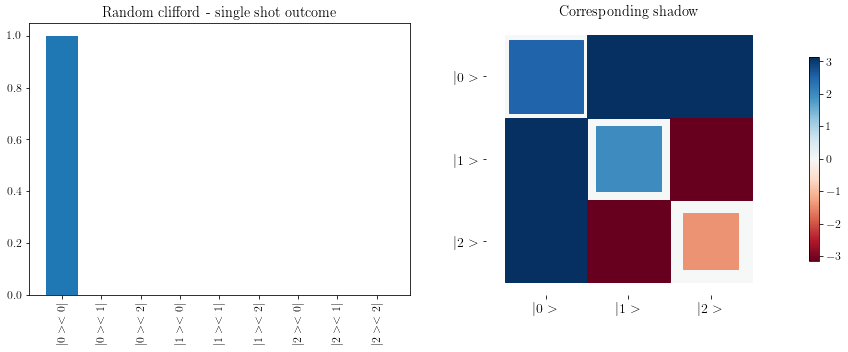

In [30]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 2, 1)
ax.bar(np.arange(1,(3 ** n_qutrits) ** 2 + 1), np.real(dense(outcomes[0][0])).reshape(-1))
ax.set_xticks(np.arange(1,(3 ** n_qutrits) ** 2 + 1))
ax.set_xticklabels(density_labels,rotation=90)
ax.set_title("Random clifford - single shot outcome")


ax = fig.add_subplot(1, 2, 2)
qt.hinton(shadows[0].reshape(3**n_qutrits, 3**n_qutrits),xlabels=ket_labels,ylabels=ket_labels, ax=ax, label_top=False)
ax.set_title("Corresponding shadow")
plt.show()

In [31]:
estimate = tomo.calculate_estimators(1)[0]

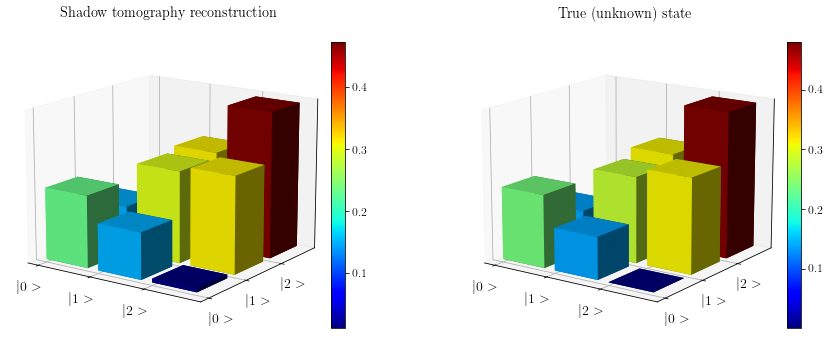

In [32]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1, 2, 1, projection='3d')
qt.matrix_histogram(np.array(estimate).reshape(3**n_qutrits, 3**n_qutrits),xlabels=ket_labels,ylabels=ket_labels, ax=ax)
ax.view_init(azim=-55, elev=15)
ax.set_title("Shadow tomography reconstruction")

ax = fig.add_subplot(1, 2, 2, projection='3d')
qt.matrix_histogram(dense(state).reshape(3**n_qutrits, 3**n_qutrits),xlabels=ket_labels,ylabels=ket_labels, ax=ax)
ax.view_init(azim=-55, elev=15)
ax.set_title("True (unknown) state")

plt.show()

We have reconstructed our qutrit state from **9 random clifford measurements**. The cool thing is we can just run them at random and store the results. 

But we might not be amazed that 9 measurements allowed us to reconstruct a density matrix with 9 parameters. Let's try doing it with less.

In [35]:
# single shot per random clifford
n_shots = 1024

# randomly subselect a small number of cliffords to measure
n_observables = 2
random_observables = [cliffs_sup[k] for k in np.random.permutation(n_observables)]

# Let's simulate the measurements
outcomes = []
for c in random_observables:
    outcomes.append(
        [measure(c @ state, basis_sup) for _ in range(n_shots)]
    )
    
tomo = ShadowTomography(state, random_observables, basis_sup, n_shots, measurements=outcomes)
estimate = tomo.calculate_estimators(1)[0]

Here's what we get with just **2 random measurements**! It's obviously a lower fidelity reconstruction, but it's still pretty good considering we demanded significantly less resources to obtain it.

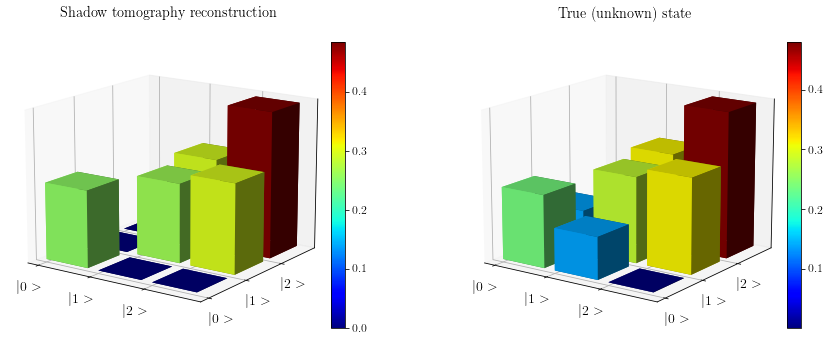

In [36]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1, 2, 1, projection='3d')
qt.matrix_histogram(np.array(estimate).reshape(3**n_qutrits, 3**n_qutrits),xlabels=ket_labels,ylabels=ket_labels, ax=ax)
ax.view_init(azim=-55, elev=15)
ax.set_title("Shadow tomography reconstruction")

ax = fig.add_subplot(1, 2, 2, projection='3d')
qt.matrix_histogram(dense(state).reshape(3**n_qutrits, 3**n_qutrits),xlabels=ket_labels,ylabels=ket_labels, ax=ax)
ax.view_init(azim=-55, elev=15)
ax.set_title("True (unknown) state")

plt.show()

## Predicting properties of multi-qutrit systems

This was cool, but one of the best parts of shadows is predicting properties of a state, when you don't actually need a full tomographic reconstruction of the state.

This actually encompasses many quantum applications (both academic and commercial). We will demonstrate this using a multi-qutrit GHZ state 

$$
|\mathrm{GHZ}\rangle = \frac{|000\rangle + |111\rangle + |222\rangle}{\sqrt{3}}
$$

where we want to some observables for an entanglement witness. The ability to reliably prepare entangled states is an important benchmark for quantum computers.

This is something we could do one of the multi-transmon devices such as `ibm-casablanca` and `ibm-bogota`

In [37]:
n_qutrits = 3

zero = reduce(qt.tensor, [qt.basis(3,0) for _ in range(n_qutrits)])
one = reduce(qt.tensor, [qt.basis(3,1) for _ in range(n_qutrits)])
two = reduce(qt.tensor, [qt.basis(3,2) for _ in range(n_qutrits)])

state = to_super(zero + one + two) / np.sqrt(3)


In [38]:
# make some labels for 3 qutrits
density_labels = ["$|{}><{}|$".format(i,j) for (i,j) in product(product(range(3), repeat=n_qutrits),repeat=2)]
ket_labels = ["$|{}{}{}>$".format(*i) for i in product(range(3), repeat=n_qutrits)]

In [39]:
# 3 qutrit computational basis

comp_basis = computational_basis(n_qutrits)
basis_sup = [to_super(b) for b in comp_basis]

In [156]:
# single shot per random clifford
n_shots = 1024

# randomly subselect a small number of cliffords to measure
n_measurements = 12
random_observables = [to_super(reduce(sp.sparse.kron, [random_qutrit_clifford() for site in range(n_qutrits)]))
                      for _ in range(n_measurements)]


# Let's simulate the measurements
outcomes = []
for c in random_observables:
    outcomes.append(
        [measure(c @ state, basis_sup) for _ in range(n_shots)]
    )

In [157]:
tomo = ShadowTomography(state, random_observables, basis_sup, n_shots, measurements=outcomes)

In [ ]:
shadows = tomo.calculate_shadows()

This time all we want to do is predict the 9 necessary obervables needed to measure entanglement witness. These are the basis states supported in the GHZ state i.e. $|000\rangle\langle000|, |000\rangle\langle111|, ... |222\rangle\langle 222|$ 

In [ ]:
# we want to estimate the 9 observables as a median of means of k estimators
estimates = tomo.calculate_estimators(1)

In [ ]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1, 2, 1, projection='3d')
qt.matrix_histogram(np.array(np.mean(estimates,axis=0)).reshape(3**n_qutrits, 3**n_qutrits),xlabels=ket_labels,ylabels=ket_labels, ax=ax)
ax.view_init(azim=-55, elev=15)
ax.set_title("Shadow tomography reconstruction")

ax = fig.add_subplot(1, 2, 2, projection='3d')
qt.matrix_histogram(dense(state).reshape(3**n_qutrits, 3**n_qutrits),xlabels=ket_labels,ylabels=ket_labels, ax=ax)
ax.view_init(azim=-55, elev=15)
ax.set_title("True (unknown) state")

plt.show()

In [ ]:
# This time all we want to do is predict the 9 necessary obervables needed to measure entanglement witness
# These are the basis states supported in the GHZ state i.e. |000><000|, |000><111|, ... |222><222| 
entanglement_observables = [to_super(iii * jjj.dag()) for iii,jjj in product([zero, one, two], repeat=2)]

In [ ]:
ideal_expectations = []
shadow_expectations = []
for o in entanglement_observables:
    ideal_expectations.append(dense(state.T.conj() @ o @ state)[0,0])
    shadow_expectations.append(np.median([(rhohat.T.conj() @ o @ rhohat)[0,0] for rhohat in estimates]))

In [ ]:
plt.step(np.arange(len(ideal_expectations))+1,ideal_expectations, where='mid')
plt.step(np.arange(len(ideal_expectations))+1,shadow_expectations, where='mid')